<a href="https://colab.research.google.com/github/chaordichris/KRTH/blob/main/KRTH_Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter 3: More on R, probability, drift, and volatility

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: xlabel='Date'>

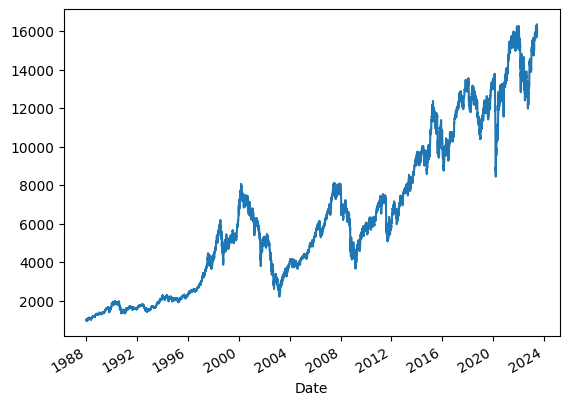

In [ ]:
## Getting and plotting data on DAX
!pip install yfinance
import yfinance as yf
import seaborn as sns

dax = yf.Ticker("^GDAXI")
df = dax.history(period='max')
# calculate daily returns
df['daily_returns'] = (df['Close']/df['Close'].shift(1)) - 1
# plot the daily close
df['Close'].plot()

<Axes: xlabel='Date'>

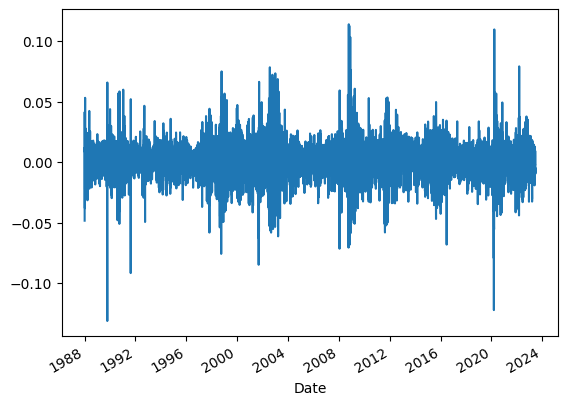

In [ ]:
# plot the daily returns
df['daily_returns'].plot()

Review some formulas from probability theory:

Normal PDF: $f(x|\mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$

Normal CDF: $P(X \leq x) = \int\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}dx$

**Note $\mu$ and $\sigma$ are simply the expectation and the variance**

Expectation of Continuous RV: $E[X] := \int_{-∞}^{∞}xf(x)dx$

Variance of Continuous RV: $VAR[X]:= \int_{-∞}^{∞}(x-E[X])^{2}dx$

In the future, we might want to condsider the mixture distribution as follows:
$r:=\lambda X + (1-\lambda)D$

where r is a DAX return, D is a drawdown amplitude, and $\lambda$ is a binomially distributed random variable which takes values in either 0 or 1. The book doesn't note, but I believe this can be fit with relative ease using the expectation maximization algorithm and some python/R libraries. We can try to explore this at the end.

<Axes: ylabel='Density'>

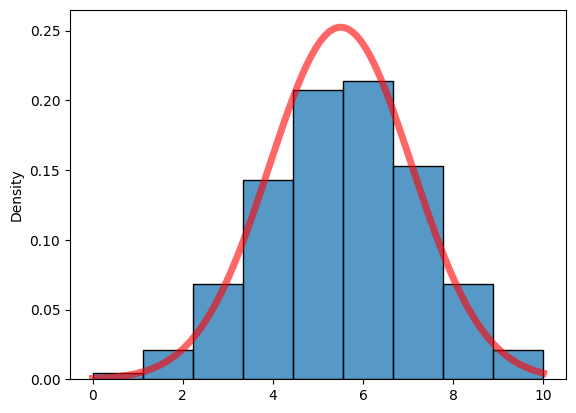

In [ ]:
## show the relationship between the binomial and the normal distribution
## simply, the binomial distribution with probability p and n chances can be represented by the mean np and the stdev np(1-p)^0.5.
## we show this visually in the graphic below

from scipy.stats import binom
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

n_tosses = 10
n_sims = 100000
coinTosses = binom.rvs(10, 0.55, size=n_sims)
fig, ax = plt.subplots(1, 1)
x = np.linspace(min(coinTosses),
                max(coinTosses), 100)
ax.plot(x, norm.pdf(x, loc=np.mean(coinTosses), scale = np.std(coinTosses)),
       'r-', lw=5, alpha=0.6, label='norm pdf')
sns.histplot(coinTosses, bins=9, ax=ax, stat='density')




<Axes: ylabel='Density'>

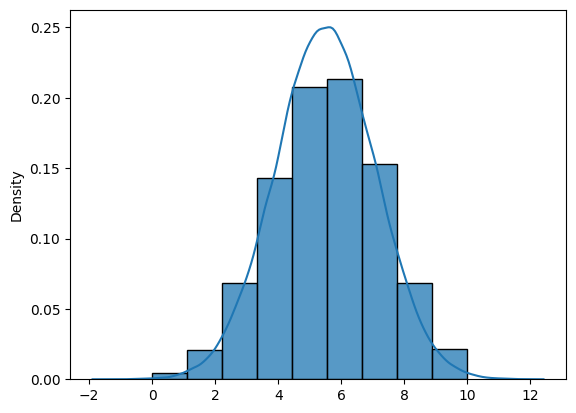

In [ ]:
# now we'll plot the densities of the binomial and the normal distribution
# using simulations in both instances instead of using the theoretical normal distribution

mu = np.mean(coinTosses)
sigma = np.std(coinTosses)
normalrv = norm.rvs(loc = mu, scale = sigma, size=n_sims)

ax = sns.kdeplot(normalrv)
sns.histplot(coinTosses, bins=9, stat='density')

<ipython-input-5-63fb018c1864>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df['daily_returns'])


<Axes: xlabel='daily_returns', ylabel='Density'>

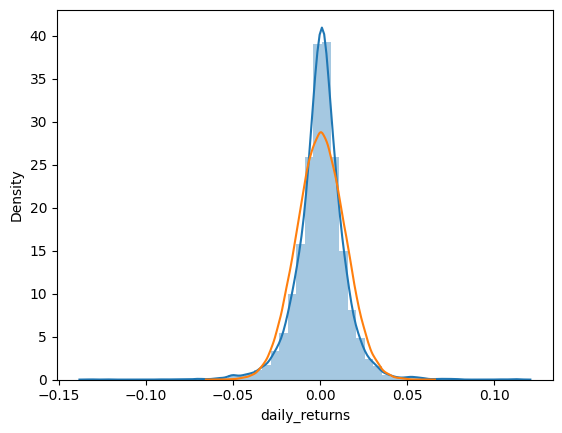

In [ ]:
## plot the qq plot fo dax returns as well as the theoretical density vs the actual density of dax returns
import statsmodels.api as sm
mu = df['daily_returns'].mean()
sigma = df['daily_returns'].std()
ax = sns.distplot(df['daily_returns'])
dax_norm = norm.rvs(loc = mu, scale = sigma, size=n_sims)
sns.kdeplot(dax_norm, ax=ax)


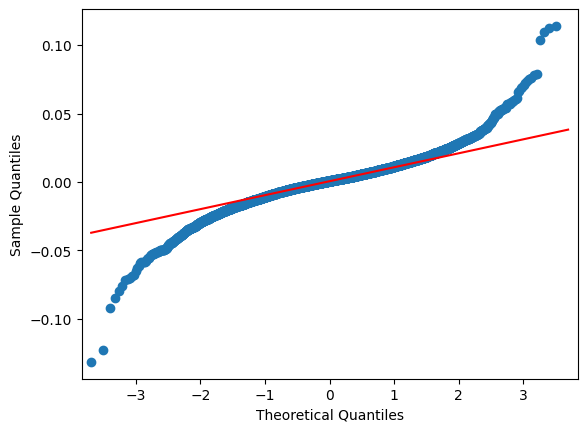

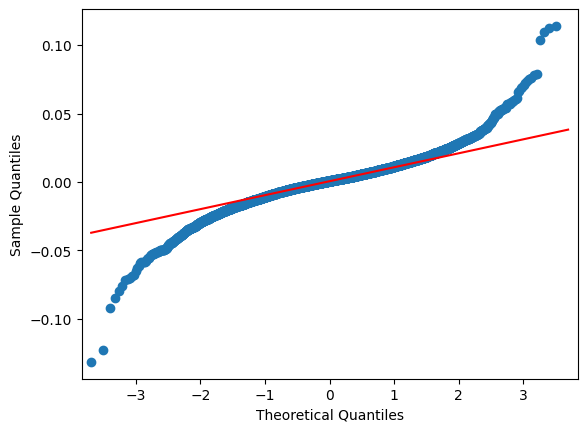

In [ ]:
sm.qqplot(df['daily_returns'], line='q')

Looking at the density of the DAX daily returns or the qqplot, there is evidence of heavy tails, meaning that we see more observations in the tails of the DAX returns than we would expect to see if the data closely followed a normal distribution.

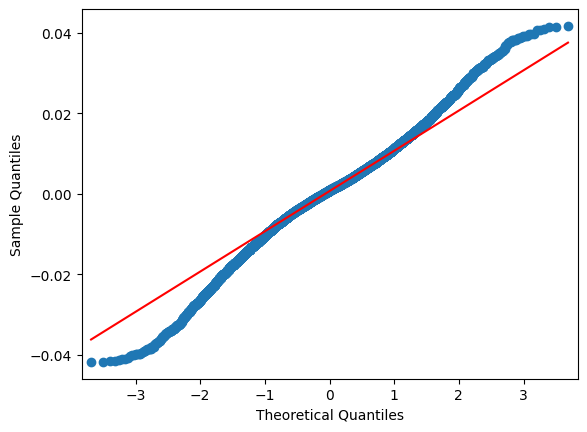

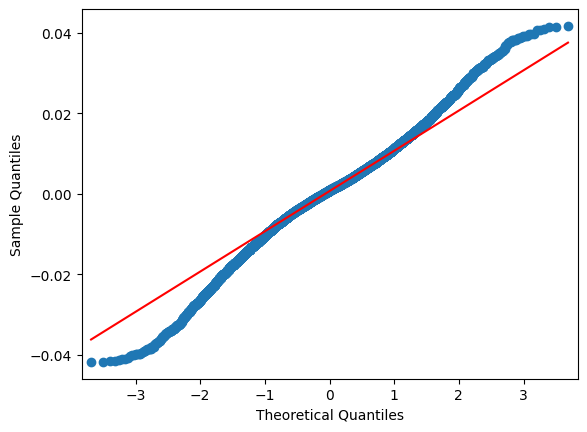

In [ ]:
## were now going to lookat capped returns, ie we are going to exclude days that are > 3 standard deviation days
cap = 3.0 * df['daily_returns'].std()
df_cap = df.loc[(df['daily_returns'].abs() < cap)]

# plot the qq plot for capped returns
sm.qqplot(df_cap['daily_returns'], line='q')

The tails look at little better once they are trimmed of large outliers. However this is an approach which we should be cautious of because these observations are a part of reality and ignoring them for the sake of a nice analysis may result in significant investment losses.

<Axes: xlabel='Date'>

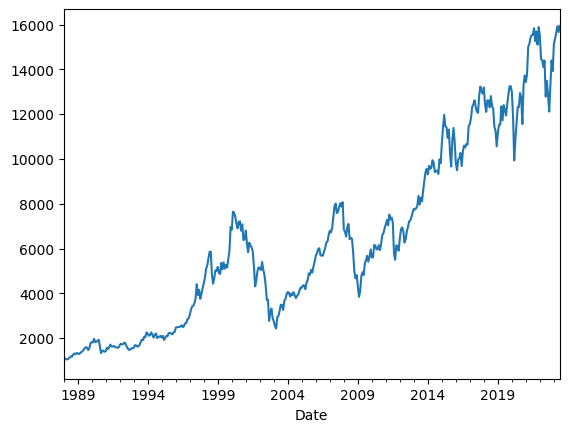

In [ ]:
# similarly we want to look at the monthly returns

dax = yf.Ticker("^GDAXI")
df = dax.history(period='max', interval = '1mo')
# calculate daily returns
df['monthly_returns'] = (df['Close']/df['Close'].shift(1)) - 1
# plot the daily close
df['Close'].plot()

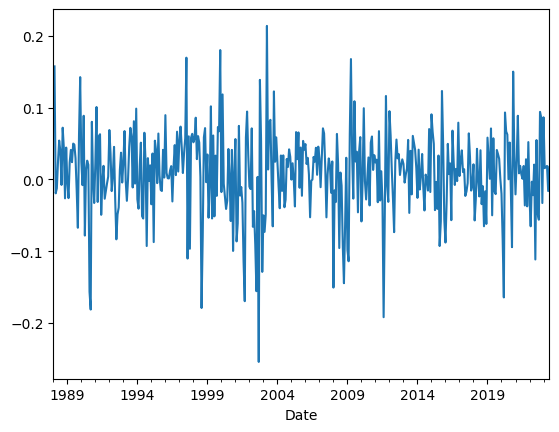

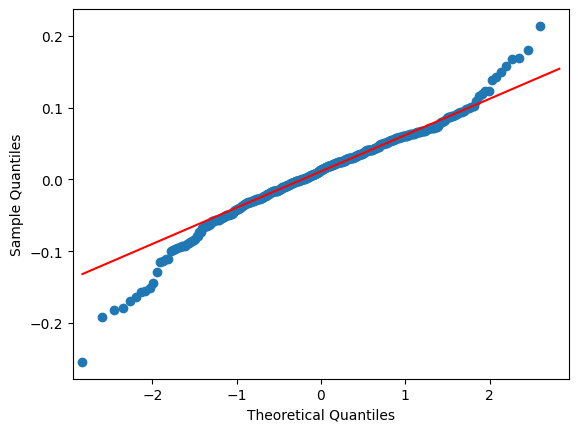

In [ ]:
# check the dax monthly returns for normality
n = len(df['monthly_returns'])
mu = df['monthly_returns'].mean()
sigma = df['monthly_returns'].std()
normal_returns = norm.rvs(loc=mu, scale=sigma, size = n)
# plot the monthly returns
df['monthly_returns'].plot()
# qqplot of normal returns to check for normality
ax = sm.qqplot(df['monthly_returns'], line='q')

<ipython-input-10-f33de28fab8a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(df['monthly_returns'])


<Axes: xlabel='monthly_returns', ylabel='Density'>

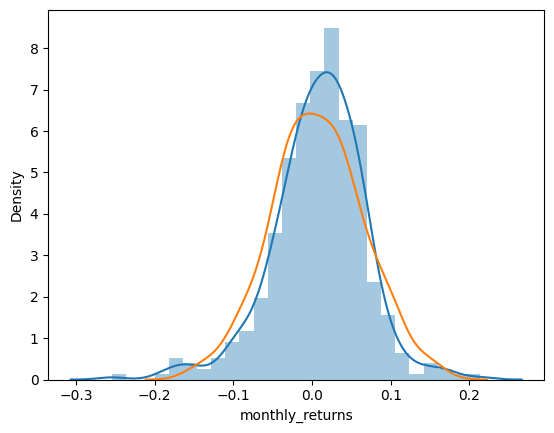

In [ ]:
# plot the observed data vs the theoretical normal distritbution
ax1 = sns.distplot(df['monthly_returns'])
sns.kdeplot(normal_returns, ax=ax1)

Looks like the normality assumption is ok for the monthly returns, there appear to be less extreme outliers in the monthly returns compared to the daily returns....this makes sense in general. There still appears to be some fat-tailedness to the monthly returns so that is something to be conscious of for the future.

WE're going to apply Kelly to a portfolio consisting of DAX and a riskless bank account.

- annual riskless interest rate of 3%, making 0.25% the monthly rate

- assume investment for 10 years or 20 months


In [ ]:
import pandas as pd
# first we want to simulate the DAX for 10 years
mu = 0.0085
sigma = 0.0605
n_simulations = 10000
n_months = 120
m = np.linspace(1, n_months, num=n_months)
# we want to loop through and do this 10,000 time and figure out what our terminal wealth will be etc.
# I think this can be done very simply using pandas and python knowledge
df = pd.DataFrame()
for i in range(0, n_simulations):
  rvs = norm.rvs(loc = mu, scale = sigma, size = n_months) # simulate 120 months worth of dax monthly returns (this is 10 years)
  w = [1.0] * n_months # 120 month list used to calculate wealth
  for j in range(1, len(w)):
    w[j] = w[j - 1] * (rvs[j - 1] + 1.0)

  dfa = pd.DataFrame({'returns':rvs, 'wealth':w, 'month':m})
  dfa['sim'] = i
  df = df.append(dfa)

Streaming output truncated to the last 5000 lines.
<ipython-input-11-e83d63f1b405>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfa)
<ipython-input-11-e83d63f1b405>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfa)
<ipython-input-11-e83d63f1b405>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfa)
<ipython-input-11-e83d63f1b405>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfa)
<ipython-input-11-e83d63f1b405>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append

The yield of a portfolio DAX and a bank account

$\mu(1+r_{dax}) + (1-\mu)(1+r) = \mu(r_{dax}-r) + (1+r)$

count    10000.000000
mean         2.741575
std          1.976672
min          0.165110
25%          1.415005
50%          2.229652
75%          3.451145
max         26.818359
Name: wealth, dtype: float64

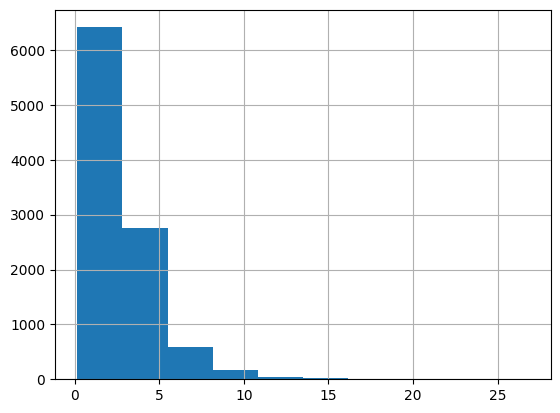

In [ ]:
df[df['month']==120]['wealth'].hist()
df[df['month']==120]['wealth'].describe()

<Axes: xlabel='month', ylabel='wealth'>

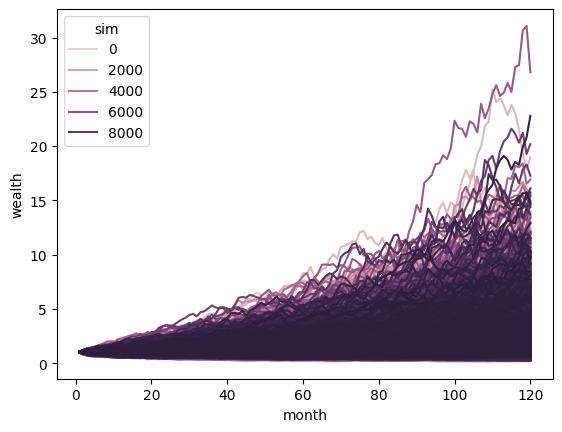

In [ ]:
# plot the simulated returns by simulation run
sns.lineplot(data=df, x='month', y='wealth', hue='sim')

<Axes: xlabel='month', ylabel='log_wealth'>

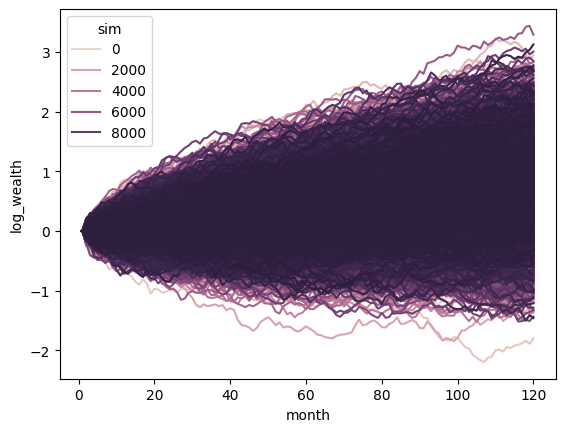

In [ ]:
# plot the simulated returns in terms of log wealth so its a little easier to visualize
df['log_wealth'] = np.log(df['wealth'])
sns.lineplot(data=df, x='month', y='log_wealth', hue='sim')

In [ ]:
# the next exercise we are going looking for the optimal kelly fraction
# so we'll need to use similar function to the above, but we'll need to iterate through all kelly scenarios
# establish some of the baseline information
n_simulations = 1000
n_months = 120
n_steps = 100
# we are going to base this off of actual monthly returns
dax = yf.download("^GDAXI", start= '1900-1-1', interval='1mo')
dax['monthly_returns'] = (dax['Close']/dax['Close'].shift(1)) - 1 # calculate the monthly returns
n = len(df)
mu = dax['monthly_returns'].mean()
sigma = dax['monthly_returns'].std()
r = 0.03 / 12.0 # monthly risk free rate

# now iterate through everything and find the optimal kelly fraction
kf = []
mlw = []
dff = pd.DataFrame()
for u in range(0, n_steps):
  df = pd.DataFrame()
  for i in range(0, n_simulations):
    rvs = norm.rvs(loc = mu, scale = sigma, size = n_months) # simulate 120 months worth of dax monthly returns (this is 10 years)
    w = [1.0] * n_months # 120 month list used to calculate wealth
    for j in range(1, len(w)):
      if rvs[j] < -0.99:
        rvs[j] = -0.99
      elif rvs[j] > 0.99:
        rvs[j] = 0.99
      else:
        pass
      port_ret = ((u / n_steps) * (rvs[j - 1] - r) + (1+r)) # kelly fraction * port returns + risk free returns
      w[j] = w[j - 1] * port_ret

    dfa = pd.DataFrame({'returns':rvs, 'wealth':w, 'month':m})
    dfa['sim'] = i
    dfa['kelly'] = u / 100
    dfa['log_wealth'] = np.log(dfa['wealth'])
    df = df.append(dfa)
dff.append(df.groupby(['kelly', 'month']).mean())

[*********************100%***********************]  1 of 1 completed


Streaming output truncated to the last 5000 lines.
<ipython-input-15-62f6469e981f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfa)
<ipython-input-15-62f6469e981f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfa)
<ipython-input-15-62f6469e981f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfa)
<ipython-input-15-62f6469e981f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfa)
<ipython-input-15-62f6469e981f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append